In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split
from sklearn.model_selection import KFold

In [115]:
class Experiment:

    def __init__(self,width,batch_size):
        self.width = width
        self.batch_size = batch_size
        self.dataset= self.Generate_data()

    def Generate_data(self):

        data = []
      
        for x in range(self.width):
            for y in range(self.width):
                data.append([x/self.width,y/self.width])
                #data.append([x/self.width,y/self.width])
        data = random.sample(data,len(data))
        data = torch.tensor(data,dtype=torch.float32)

        #target = [int(np.abs(a[1] - a[0]) <= 1/self.width) for a in data]
        target = [int(np.abs(a[1] - a[0]) <= 17/self.width) for a in data]
        target = torch.tensor(target,dtype=torch.float32)
        dataset = TensorDataset(data,target)

        return dataset

    def Create_dataset(self,train_ids,test_ids):

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(
                            self.dataset, 
                            batch_size=10, sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(
                            self.dataset,
                            batch_size=10, sampler=test_subsampler)



        return train_loader, test_loader







In [116]:
class Net(torch.nn.Module):
    def __init__(self,input_dimension, output_dimension,nodes_first):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features = input_dimension, out_features = nodes_first)
        self.fc2 = nn.Linear(in_features = nodes_first, out_features = 2)
        self.fc3 = nn.Linear(in_features = 2,  out_features = output_dimension)

        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.xavier_normal_(self.fc3.weight)


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.fc2(x)) #tanh if does not work than not a smoothness issue
        x = self.fc3(x)
        return torch.sigmoid(x)

class Training():

    # The class initialisation function.
    def __init__(self,model,opti,loss):
        self.model = model
        self.optimizer = opti
        self.criterion = loss
    
    def train_network(self,data,target):
        Loss = []  
        #Compute the prediction
        output = self.model.forward(data)
        # Calculate the loss for this transition.
        loss =  self.criterion(output,target.unsqueeze(1))
        # Set all the gradients stored in the optimiser to zero.
        self.optimizer.zero_grad()
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        loss.backward()    
        # Take one gradient step to update the Q-network. 
        self.optimizer.step()
        # Return the loss as a scalar
        return loss


In [117]:
def set_seed(seed=None, seed_torch=True):
    print("a",seed)
    print("b", seed_torch)
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')


In [118]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = torch.device("cpu")
G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)
WIDTH = 100
experiment = Experiment(width = WIDTH,batch_size=16)



a 2021
b True
Random seed 2021 has been set.


In [119]:


EPOCH = 300

Liste_lr = [0.001]

k_folds = 20
kfold = KFold(n_splits=k_folds, shuffle=True)

LOSSES_LR = [[]for i in range(k_folds)]
LOSSES_LR_val = [[]for i in range(k_folds)]
Liste_models = []

dataset = experiment.Generate_data()




i = 0

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_loader, val_loader = experiment.Create_dataset(train_ids,test_ids)
   
    model = Net(input_dimension=2,output_dimension=1,nodes_first = 1)    
    lr = Liste_lr[0]
    optimizer = torch.optim.Adam(model.parameters(), lr)
    criterion = nn.BCELoss()
    train = Training(model,optimizer,criterion)
    losses = []
    val_losses = []

    for epoch in range(EPOCH):

            
        loss = 0
        val_loss = 0 
        for x_batch, y_batch in train_loader:

            loss += train.train_network(x_batch, y_batch).detach().numpy()
        losses.append(loss/len(train_loader))
            
        with torch.no_grad():
            for x_val, y_val in val_loader:

                model.eval()

                yhat = model(x_val)
                val_loss += criterion( yhat,y_val.unsqueeze(1))
            val_losses.append(val_loss.item()/len(val_loader))


        if np.mod(epoch,20)==0:
            print(epoch)
            print("val_loss.item()",val_loss.item()/len(val_loader))

        # print('Epoch {},Loss {}'.format(epoch, val_losses[-1]))
    

    LOSSES_LR[i] = losses
    LOSSES_LR_val[i] = val_losses
    print(val_losses[-1])
    Liste_models.append(model)
    i+=1





FOLD 0
--------------------------------
0
val_loss.item() 0.6475369262695313
20
val_loss.item() 0.6494589233398438
40
val_loss.item() 0.6495611572265625
60
val_loss.item() 0.649873046875
80
val_loss.item() 0.6496347045898437
100
val_loss.item() 0.6491732025146484
120
val_loss.item() 0.649903564453125
140
val_loss.item() 0.6493951416015625
160
val_loss.item() 0.649754638671875
180
val_loss.item() 0.650092544555664
200
val_loss.item() 0.6500302124023437
220
val_loss.item() 0.6494164276123047
240
val_loss.item() 0.6494828796386719
260
val_loss.item() 0.6499495697021485
280
val_loss.item() 0.6493919372558594
0.6493116760253906
FOLD 1
--------------------------------
0
val_loss.item() 0.6566722869873047
20
val_loss.item() 0.5978078460693359
40
val_loss.item() 0.5967733764648437
60
val_loss.item() 0.5966132736206055
80
val_loss.item() 0.5966924285888672
100
val_loss.item() 0.5964794921875
120
val_loss.item() 0.5967086029052734
140
val_loss.item() 0.5968315124511718
160
val_loss.item() 0.5966

<ipython-input-121-fd7db101a0f2>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  liste_label = [np.str(i) for i in range(k_folds)]


Text(0.5, 1.0, 'Training:1600  Val:400  Batch_size:10   torch.nn.init.xavier_normal_(self.fc1.weight)')

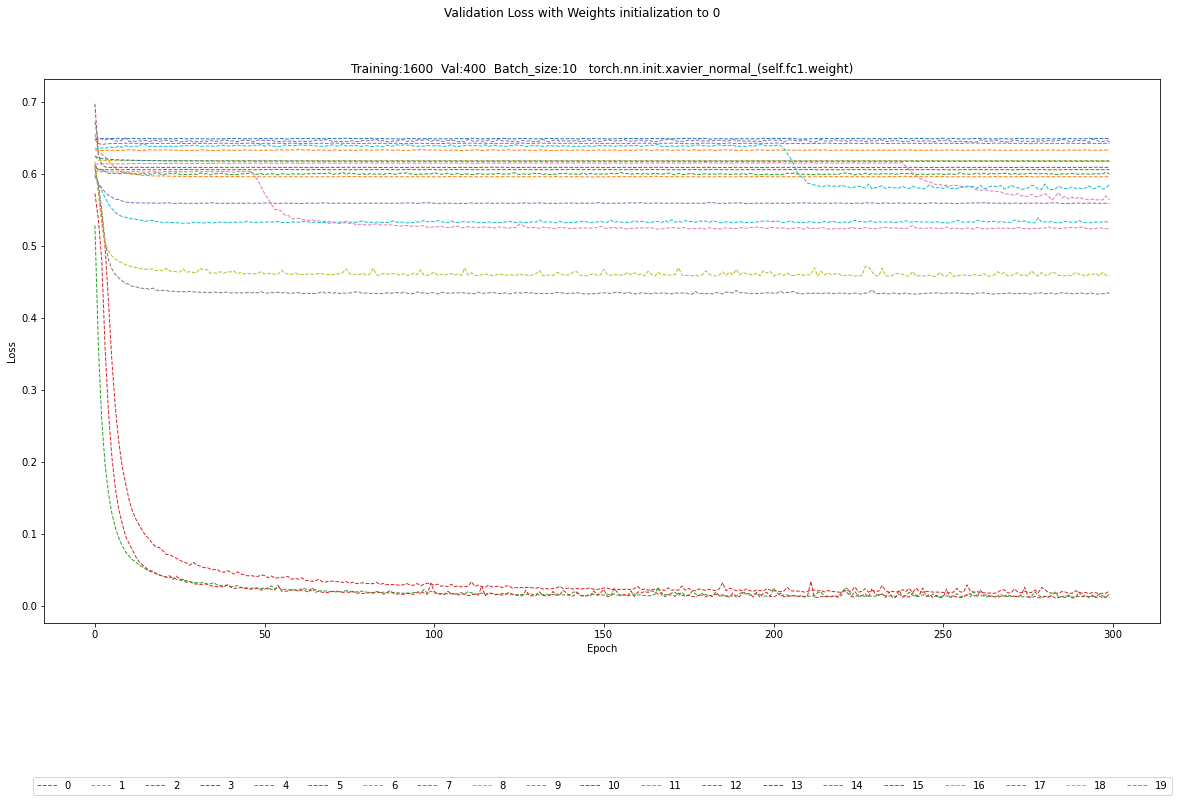

In [121]:
l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

liste_label = [np.str(i) for i in range(k_folds)]


plt.figure(figsize=(20, 10))
for i in range(k_folds):
    plt.plot(l_epoch_val,LOSSES_LR_val[i], '--', linewidth=1,label = liste_label[i])
           

           
    
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.30), shadow=False, ncol=k_folds)
plt.suptitle("Validation Loss with Weights initialization to 0 ")
plt.title("Training:1600  Val:400  Batch_size:10   torch.nn.init.xavier_normal_(self.fc1.weight)")


<ipython-input-114-56e4d02823ca>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  liste_label = [np.str(i) for i in range(k_folds)]


Text(0.5, 1.0, 'Training:1600  Val:400  Batch_size:10   torch.nn.init.zeros_(self.fc1.weight)')

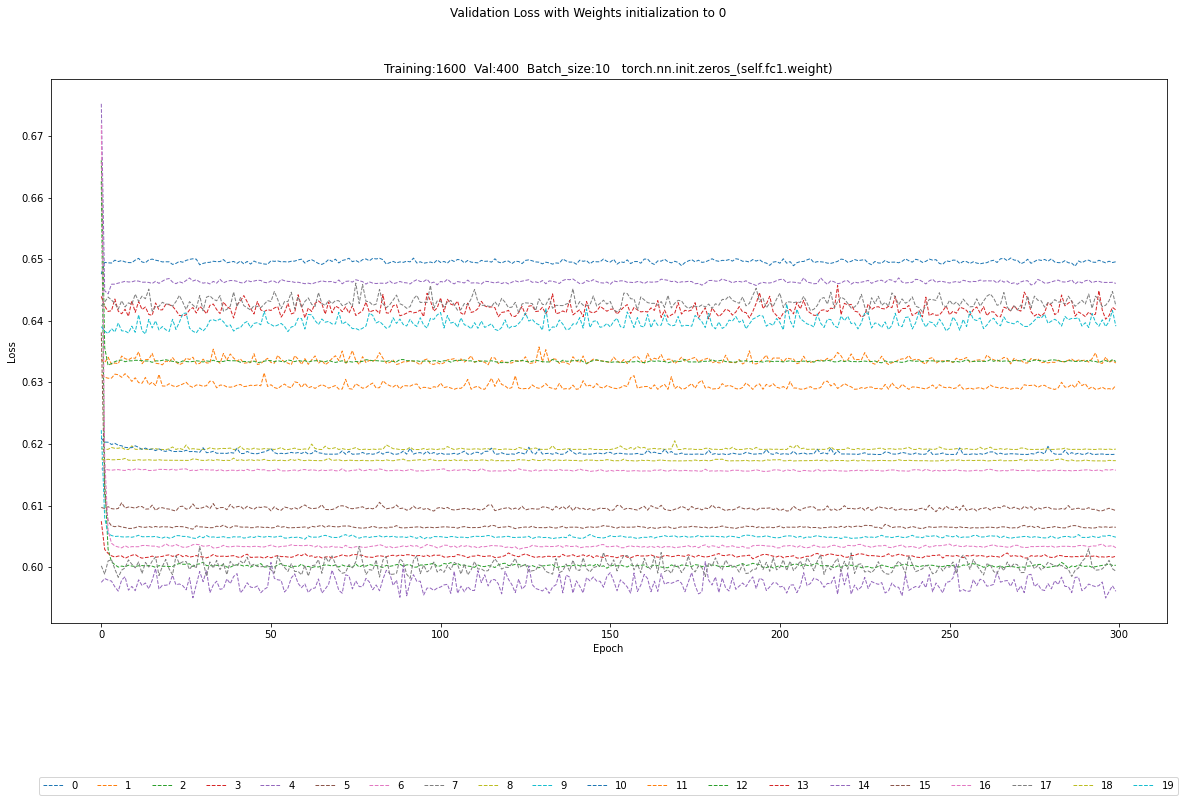

In [114]:
l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

liste_label = [np.str(i) for i in range(k_folds)]


plt.figure(figsize=(20, 10))
for i in range(k_folds):
    plt.plot(l_epoch_val,LOSSES_LR_val[i], '--', linewidth=1,label = liste_label[i])
           

           
    
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.30), shadow=False, ncol=k_folds)
plt.suptitle("Validation Loss with Weights initialization to 0 ")
plt.title("Training:1600  Val:400  Batch_size:10   torch.nn.init.zeros_(self.fc1.weight)")


<ipython-input-108-f7e52dbed178>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  liste_label = [np.str(i) for i in range(k_folds)]


Text(0.5, 1.0, 'Training:1600  Val:400  Batch_size:10')

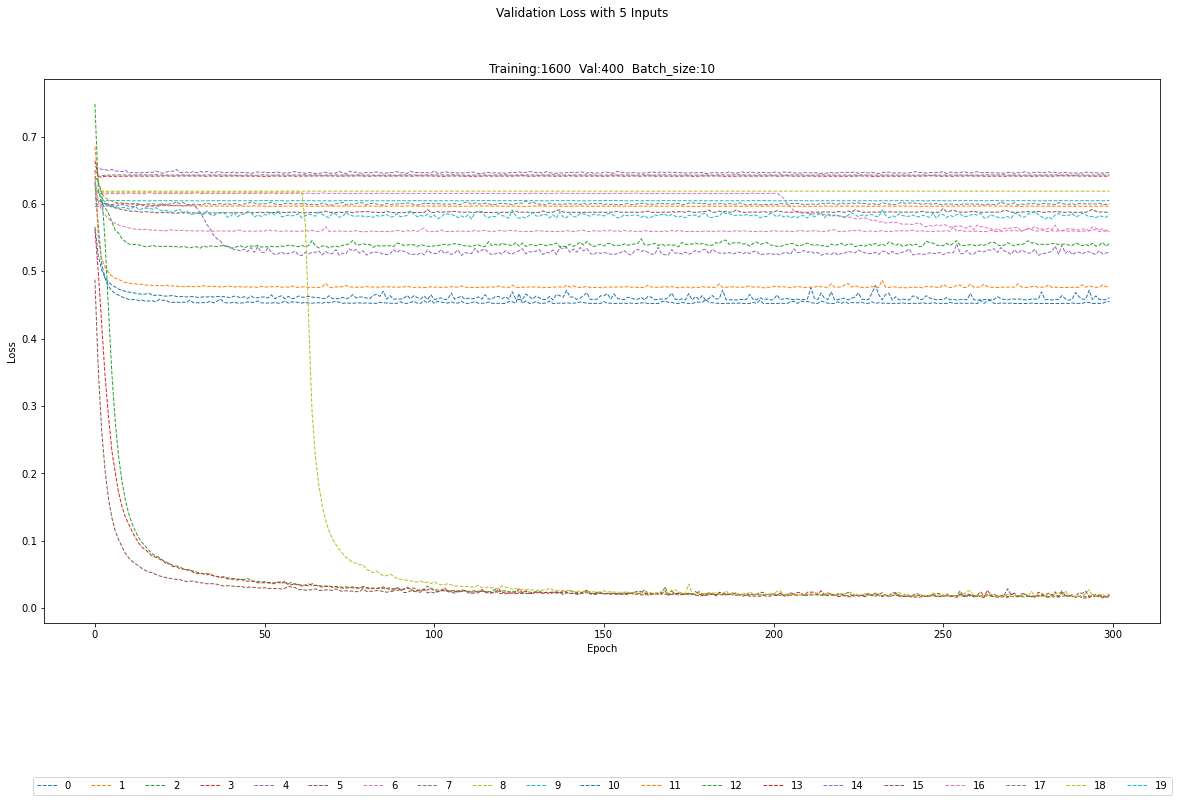

In [108]:
l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

liste_label = [np.str(i) for i in range(k_folds)]


plt.figure(figsize=(20, 10))
for i in range(k_folds):
    plt.plot(l_epoch_val,LOSSES_LR_val[i], '--', linewidth=1,label = liste_label[i])
           

           
    
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.30), shadow=False, ncol=k_folds)
plt.suptitle("Validation Loss with 5 Inputs ")
plt.title("Training:1600  Val:400  Batch_size:10")


<ipython-input-99-f7e52dbed178>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  liste_label = [np.str(i) for i in range(k_folds)]


Text(0.5, 1.0, 'Training:1600  Val:400  Batch_size:10')

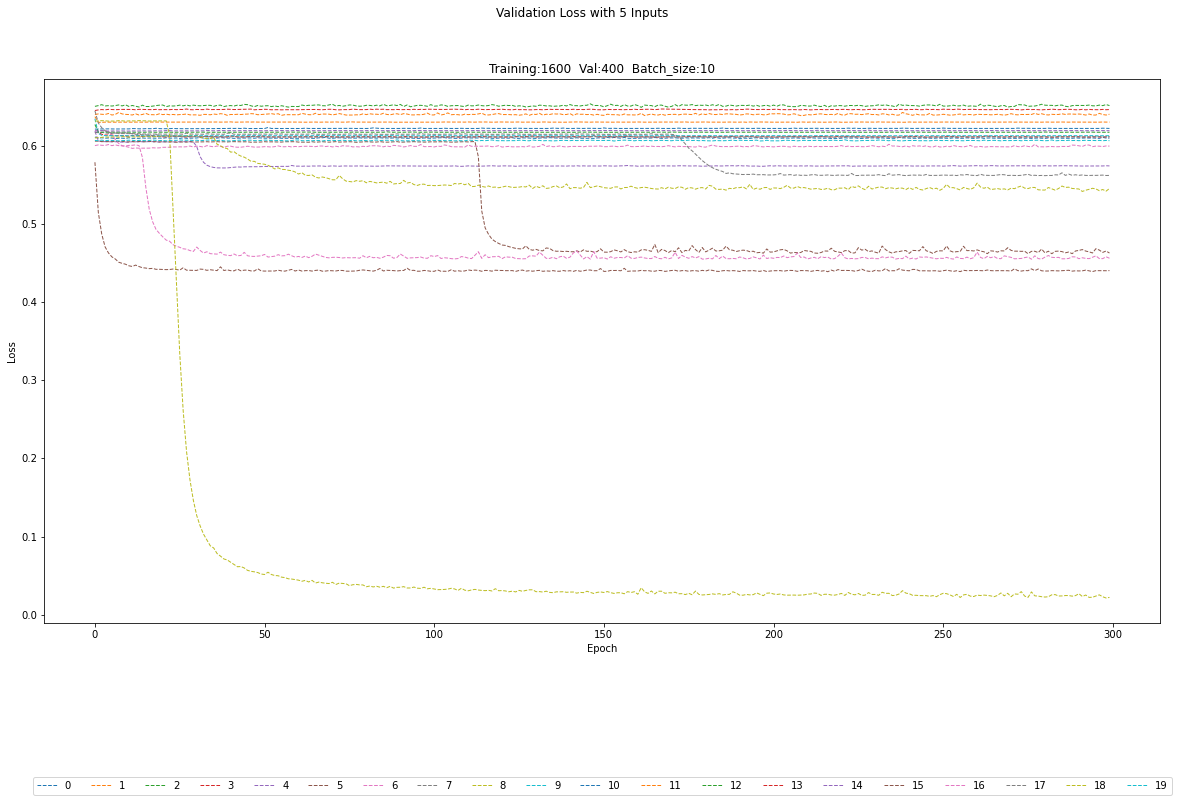

In [99]:
l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

liste_label = [np.str(i) for i in range(k_folds)]


plt.figure(figsize=(20, 10))
for i in range(k_folds):
    plt.plot(l_epoch_val,LOSSES_LR_val[i], '--', linewidth=1,label = liste_label[i])
           

           
    
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.30), shadow=False, ncol=k_folds)
plt.suptitle("Validation Loss with 5 Inputs ")
plt.title("Training:1600  Val:400  Batch_size:10")


In [100]:
accuracy = 0
treshold = 0.1
model = Liste_models[18]
for x_val,y_val in val_loader:

    with torch.no_grad():
        yhat = model(x_val)
        print(yhat)
        print(y_val)
        for i in range(len(y_val)):
            if np.abs(yhat[i]-y_val[i])<treshold:
                accuracy +=1


print("Accuracy", accuracy/(10*len(val_loader)))

tensor([[5.4159e-04],
        [0.0000e+00],
        [1.0000e+00],
        [6.3312e-30],
        [5.4159e-04],
        [5.4159e-04],
        [0.0000e+00],
        [1.0000e+00],
        [0.0000e+00],
        [5.4159e-04]])
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])
tensor([[1.0000e+00],
        [9.9985e-01],
        [4.8514e-01],
        [4.9403e-01],
        [5.4159e-04],
        [5.4159e-04],
        [5.4159e-04],
        [1.0000e+00],
        [0.0000e+00],
        [5.4159e-04]])
tensor([1., 1., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor([[2.7394e-10],
        [9.9999e-01],
        [1.0000e+00],
        [2.8275e-02],
        [2.6062e-08],
        [5.4159e-04],
        [9.9983e-01],
        [5.4159e-04],
        [2.2380e-08],
        [5.4159e-04]])
tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([[1.0000e+00],
        [1.0000e+00],
        [2.3431e-05],
        [3.3185e-17],
        [2.7475e-13],
        [5.4159e-04],
        [1.0000e+00],
        [6.4902e-01],
        [4.398

In [103]:
PATH = "Model_2_nodes.pth"

torch.save(model, PATH)